---
7 Time Series
Authors: Cumhur Erkut, Ernests Lavrionivs
---

In [ ]:
try:
  import google.colab
  IN_COLAB = True
  ! mkdir -p ../data
  ! mkdir -p common
  ! wget https://raw.githubusercontent.com/SMC-AAU-CPH/ML-For-Beginners/main/7-TimeSeries/data/energy.csv -P ../data
  ! wget https://raw.githubusercontent.com/SMC-AAU-CPH/ML-For-Beginners/main/7-TimeSeries/common/utils.py -P common
  ! wget https://raw.githubusercontent.com/SMC-AAU-CPH/ML-For-Beginners/main/7-TimeSeries/1-Introduction/solution/common/extract_data.py -P common
  ! pip install statsmodels pyramid-arima
except:
  IN_COLAB = False


# 7.1 Introduction
Where we learn about time series forecasting, an interesting and valuable part of a ML scientist's repertoire

Time series forecasting: based on past performance of a variable such as price, we predict its future potential value. Make sure to read the introduction [7-TimeSeries/README.md](https://github.com/SMC-AAU-CPH/ML-For-Beginners/tree/main/7-TimeSeries) to learn about the important concepts and definitions, such as

* 🎓 Time series
* Time series analysis
* Time series forecasting 

and the time series data characteristics to consider, such as trends, seasonality, outliers, long-run cycle, constant variance and abrupt changes. 

![Summary of time series in a sketchnote](https://github.com/SMC-AAU-CPH/ML-For-Beginners/raw/main/sketchnotes/ml-timeseries.png)

## 7.1.2 Exercise

Let's get started creating a time series model to predict future power usage given past usage.

> The data in this example is taken from the GEFCom2014 forecasting competition. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014.
>
> Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [3]:
# load and visualize data using the custom library "common"
import os
import matplotlib.pyplot as plt
from common.utils import load_data

%matplotlib inline

In [5]:
data_dir = '../data'
energy = load_data(data_dir)[['load']]
energy.head()

,load
2012-01-01 00:00:00,2698.0
2012-01-01 01:00:00,2558.0
2012-01-01 02:00:00,2444.0
2012-01-01 03:00:00,2402.0
2012-01-01 04:00:00,2403.0


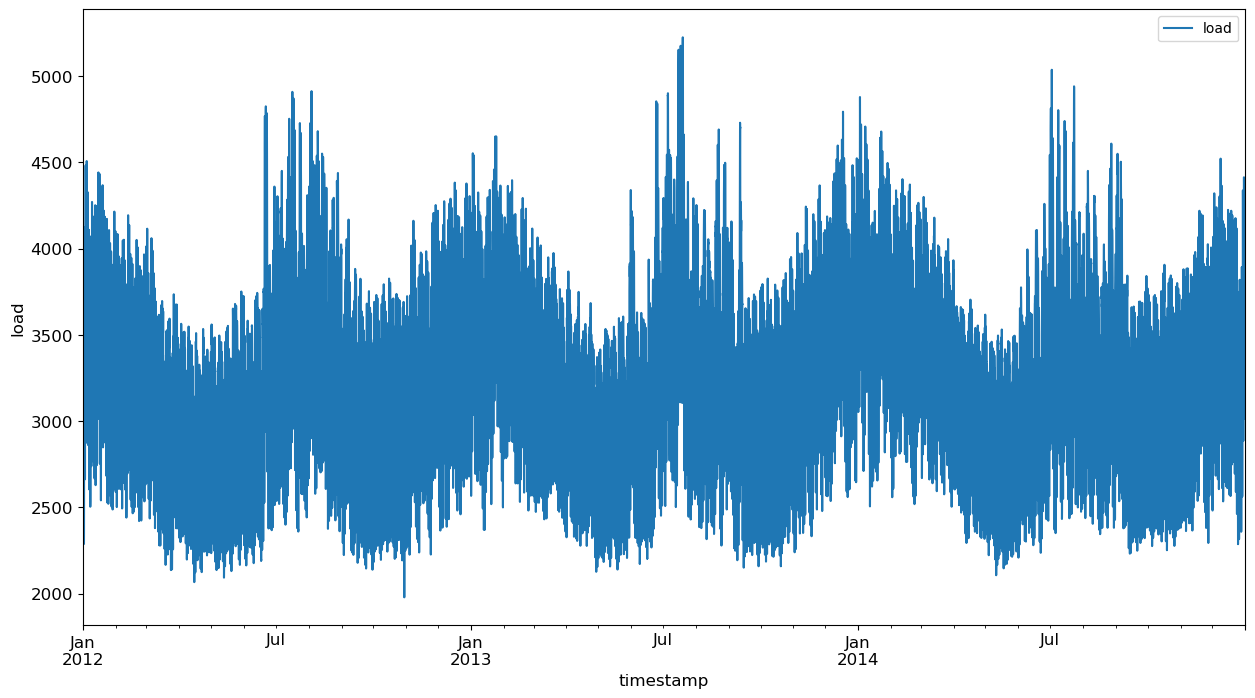

In [6]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

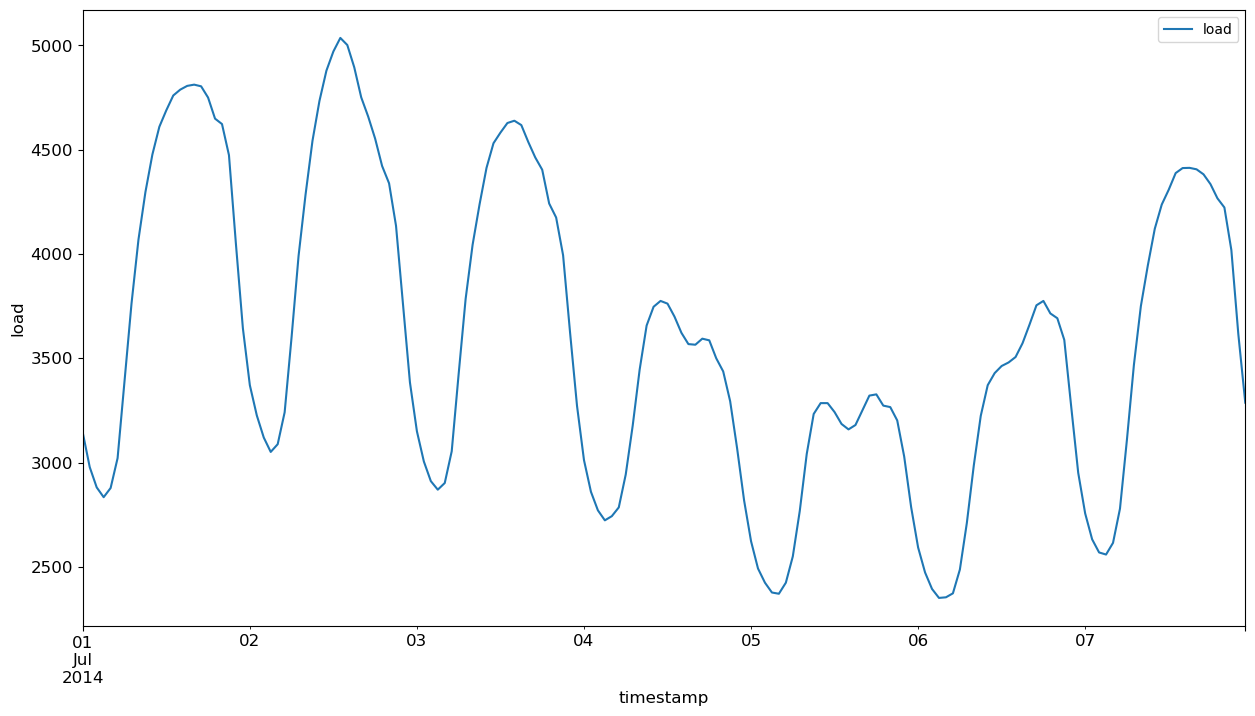

In [7]:
# plot a week of data in July 2014
energy['2014-07-01':'2014-07-07'].plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

✅ Can we determine any of the characteristics listed above? What can we surmise by visualizing the data?

# 7.2 [Time Series Forecasting](https://paperswithcode.com/task/time-series-forecasting) with ARIMA
We will discover a specific way to build models with [ARIMA: *A*uto*R*egressive *I*ntegrated *M*oving *A*verage](https://wikipedia.org/wiki/Autoregressive_integrated_moving_average). ARIMA models are particularly suited to fit data that shows [non-stationarity](https://wikipedia.org/wiki/Stationary_process).

To be able to work with ARIMA, there are some concepts you need to know about:

- 🎓 **Stationarity**. From a statistical context, stationarity refers to data whose distribution does not change when shifted in time. Non-stationary data, then, shows fluctuations due to trends that must be transformed to be analyzed. Seasonality, for example, can introduce fluctuations in data and can be eliminated by a process of 'seasonal-differencing'.
- 🎓 **[Differencing](https://wikipedia.org/wiki/Autoregressive_integrated_moving_average#Differencing)**. Differencing data, again from a statistical context, refers to the process of transforming non-stationary data to make it stationary by removing its non-constant trend. "Differencing removes the changes in the level of a time series, eliminating trend and seasonality and consequently stabilizing the mean of the time series." [Paper by Shixiong et al](https://arxiv.org/abs/1904.07632)

Let's unpack the parts of ARIMA to better understand how it helps us model time series and help us make predictions against it.

- **AR - for AutoRegressive**. Autoregressive models, as the name implies, look 'back' in time to analyze previous values in your data and make assumptions about them. These previous values are called 'lags'. An example would be data that shows monthly sales of pencils. Each month's sales total would be considered an 'evolving variable' in the dataset. This model is built as the "evolving variable of interest is regressed on its own lagged (i.e., prior) values." [wikipedia](https://wikipedia.org/wiki/Autoregressive_integrated_moving_average)
- **I - for Integrated**. As opposed to the similar 'ARMA' models, the 'I' in ARIMA refers to its *[integrated](https://wikipedia.org/wiki/Order_of_integration)* aspect. The data is 'integrated' when differencing steps are applied so as to eliminate non-stationarity.
- **MA -  for Moving Average**. The [moving-average](https://wikipedia.org/wiki/Moving-average_model) aspect of this model refers to the output variable that is determined by observing the current and past values of lags.

Bottom line: ARIMA is used to make a model fit the special form of time series data as closely as possible.


### 7.2.1 Exercise  - build an ARIMA model

In [8]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [9]:
# load data
energy = load_data('../data')[['load']]
energy.head(10)

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"
2012-01-01 05:00:00,"2,453.00"
2012-01-01 06:00:00,"2,560.00"
2012-01-01 07:00:00,"2,719.00"
2012-01-01 08:00:00,"2,916.00"
2012-01-01 09:00:00,"3,105.00"


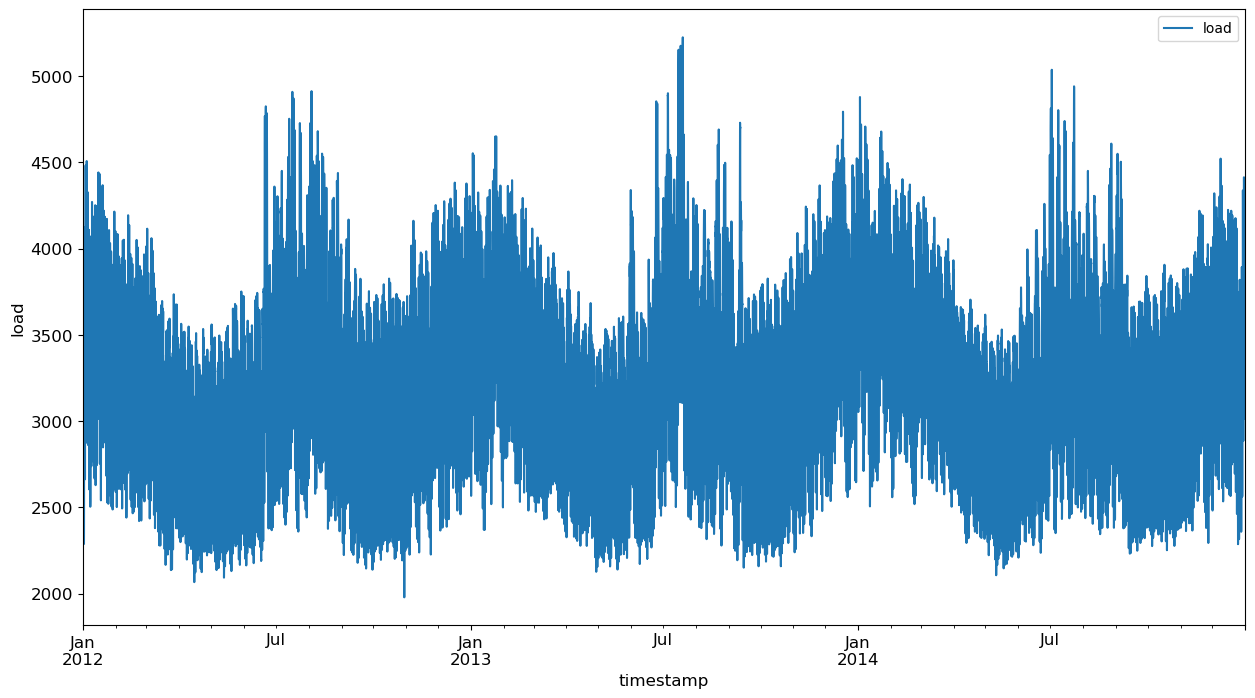

In [11]:
# Plot all the available energy data from January 2012 to December 2014. 
# There should be no surprises as we saw this data in 7.1:

energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [12]:
# Create training and testing datasets, note the strong seasonal component in the data
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'


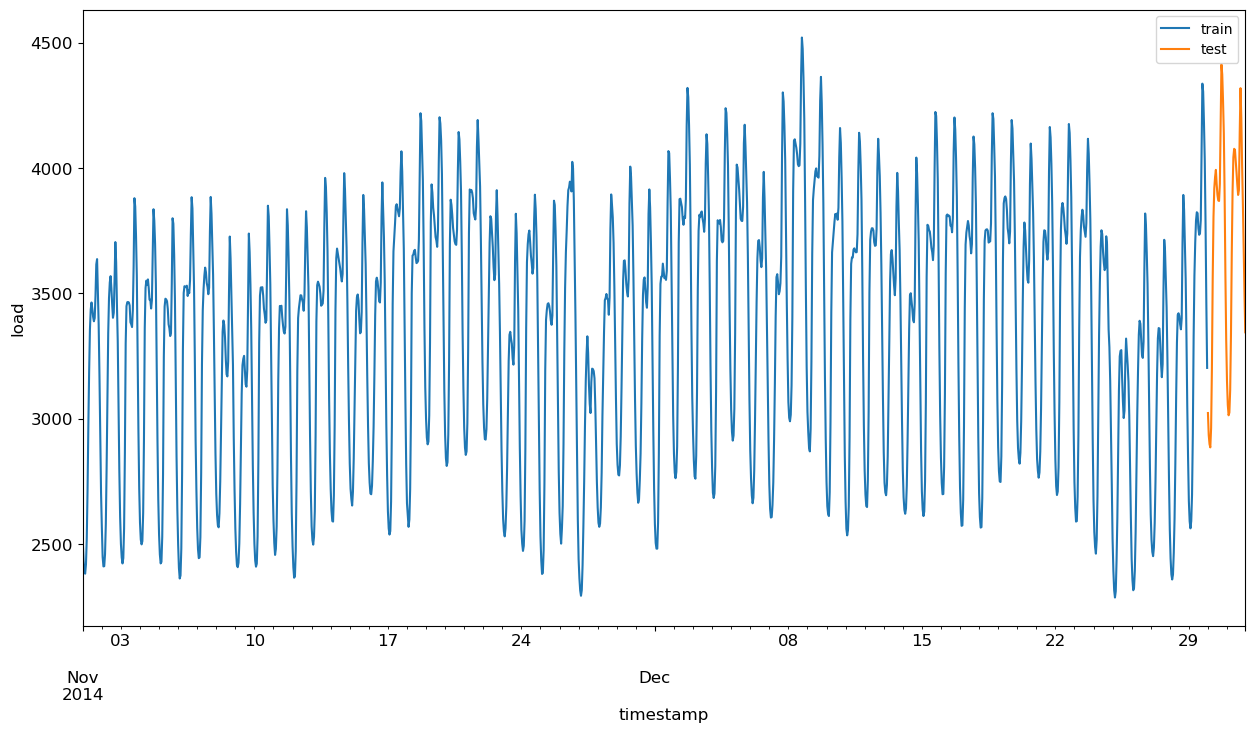

In [13]:
# Visualize the differences
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Note: A relatively small window of time for training data should be sufficient.
Since the function we use to fit the ARIMA model uses in-sample validation during fitting, we will omit validation data.

#### Prepare the data for training
Filter your dataset to only include the time periods and columns you need, and scaling to ensure the data is projected in the interval 0,1.

In [14]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [15]:
# scale
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
2014-11-01 00:00:00,0.10
2014-11-01 01:00:00,0.07
2014-11-01 02:00:00,0.05
2014-11-01 03:00:00,0.04
2014-11-01 04:00:00,0.06
2014-11-01 05:00:00,0.10
2014-11-01 06:00:00,0.19
2014-11-01 07:00:00,0.31
2014-11-01 08:00:00,0.40
2014-11-01 09:00:00,0.48


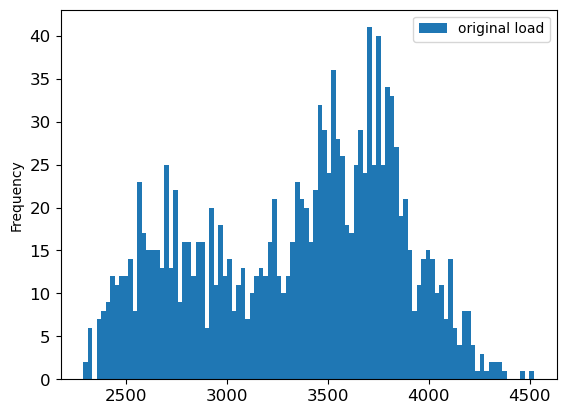

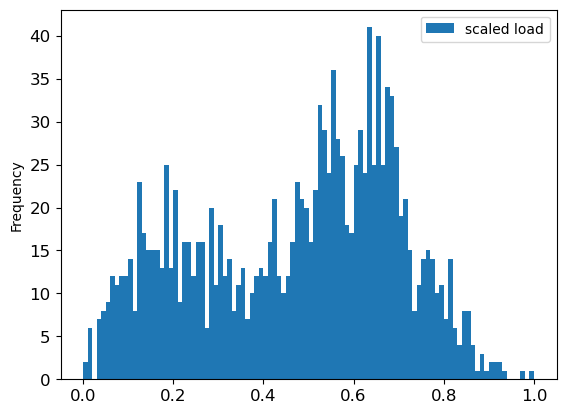

In [16]:
# Visualize the differences
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()


In [17]:
# scale also the test data
test['load'] = scaler.transform(test)
test.head()

,load
2014-12-30 00:00:00,0.33
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.27
2014-12-30 03:00:00,0.27
2014-12-30 04:00:00,0.30


#### Implement ARIMA
We use the `statsmodels` library. Our steps:
1. Define the model by calling `SARIMAX()` (seasonal ARIMA) and passing in the model parameters: p, d, and q parameters, and P, D, and Q parameters.
2. Prepare the model for the training data by calling the fit() function.
3. Make predictions calling the `forecast()` function and specifying the number of steps (the `horizon`) to forecast.

> 🎓 What are all these parameters for? In an ARIMA model there are 3 parameters that are used to help model the major aspects of a time series: seasonality, trend, and noise. These parameters are:
- `p`: the parameter associated with the auto-regressive aspect of the model, which incorporates *past* values.
- `d`: the parameter associated with the integrated part of the model, which affects the amount of *differencing* (🎓 remember differencing 👆?) to apply to a time series.
- `q`: the parameter associated with the moving-average part of the model.

In [18]:
# horizon value: 3 hours, i.e., the number of steps to forecast ahead
HORIZON = 3

order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.45318D+00    |proj g|=  2.50788D+00


 This problem is unconstrained.



At iterate    5    f= -2.45389D+00    |proj g|=  3.46997D-01

At iterate   10    f= -2.45561D+00    |proj g|=  7.50892D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     22      1     0     0   2.154D-02  -2.456D+00
  F =  -2.4556680618151301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.226
Date:                     

#### Evaluate
Walk-forward validation is the gold standard of time series model evaluation and is recommended for your own projects.


In [44]:
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)


,load,load+1,load+2
2014-12-30 00:00:00,0.33,0.29,0.27
2014-12-30 01:00:00,0.29,0.27,0.27
2014-12-30 02:00:00,0.27,0.27,0.30
2014-12-30 03:00:00,0.27,0.30,0.41
2014-12-30 04:00:00,0.30,0.41,0.57


In [45]:
# Above, the data is shifted horizontally according to its horizon point.
# Make predictions on your test data using this sliding window approach in a loop the size of the test data length:
# NOTE: Execution time was about 2.8 mins in my computer: 169.315 seconds. Both VSCode and Colab measure the execution time.
# Skipping %% time because it is not supported in VSCode. And silencing SARIMAX fit to avoid printing the model fit details.
# training_window = 720 # dedicate 30 days (720 hours) for training
# Should conclude in 45 iterations.

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)


for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    # Silence 
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)


2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.66] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 07:00:00
8 : predicted = [0.68 0.75 0.8 ] expected = [0.6799462846911368, 0.7309758281110115, 0.75111906893

In [46]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
# eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
# eval_df.head()

#### Check the model accuracy
Check the accuracy of your model by testing its mean absolute percentage error (MAPE) over all the predictions.

> 🧮 Show me the math**
>
> <img src="mape.png" alt="MAPE" width="300">
>
> [MAPE](https://www.linkedin.com/pulse/what-mape-mad-msd-time-series-allameh-statistics/) is used to show prediction accuracy as a ratio defined by the above formula. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points $n$. [wikipedia](https://wikipedia.org/wiki/Mean_absolute_percentage_error)

In [47]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

# calculate one step's MAPE
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')


h
t+1   0.02
t+2   0.03
t+3   0.04
Name: APE, dtype: float64
One step forecast MAPE:  1.5559764663328233 %


In [48]:
# Print the multi-step forecast MAPE:

print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

Multi-step forecast MAPE:  3.117974546958936 %


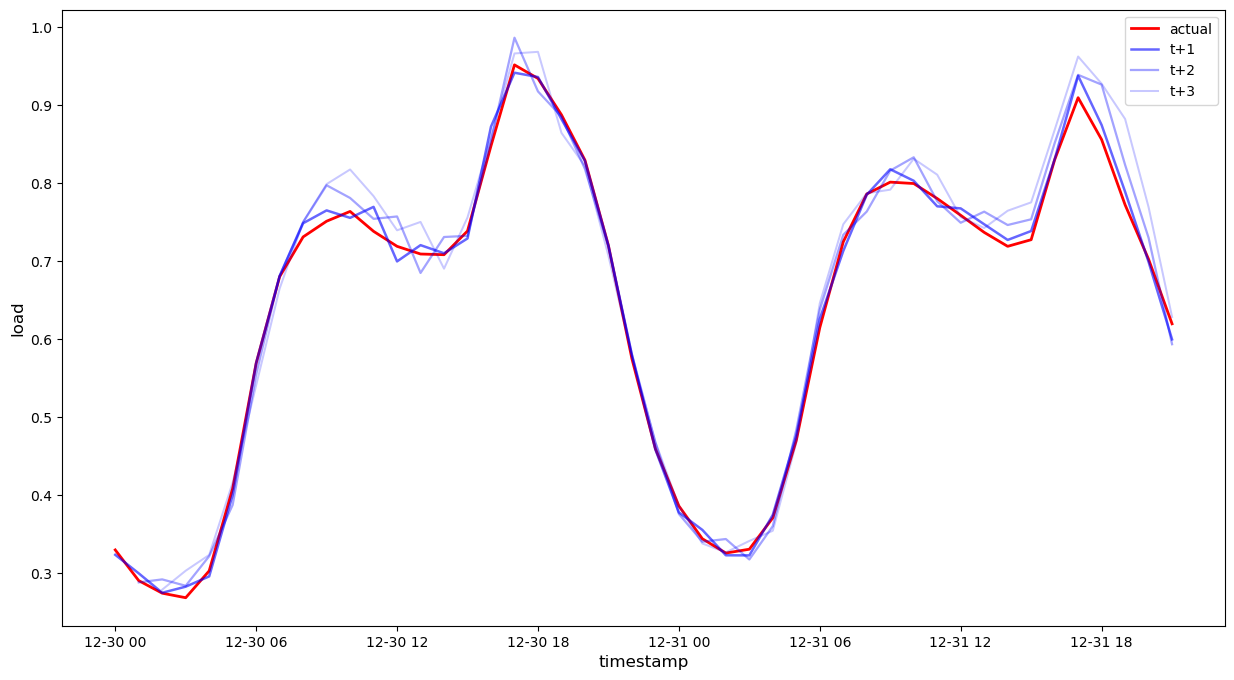

In [77]:
# show the accuracy measurement visually, with a plot

if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)   
    ax.plot(plot_df['timestamp'], plot_df['actual'], color='red',linewidth=2, label='actual')
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=2*math.pow(.9,t),alpha=math.pow(0.6,t), label='t+'+str(t))
    ax.legend(loc='best')
    
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

🏆 A very nice plot, showing a model with good accuracy. Well done!

## 7.3 